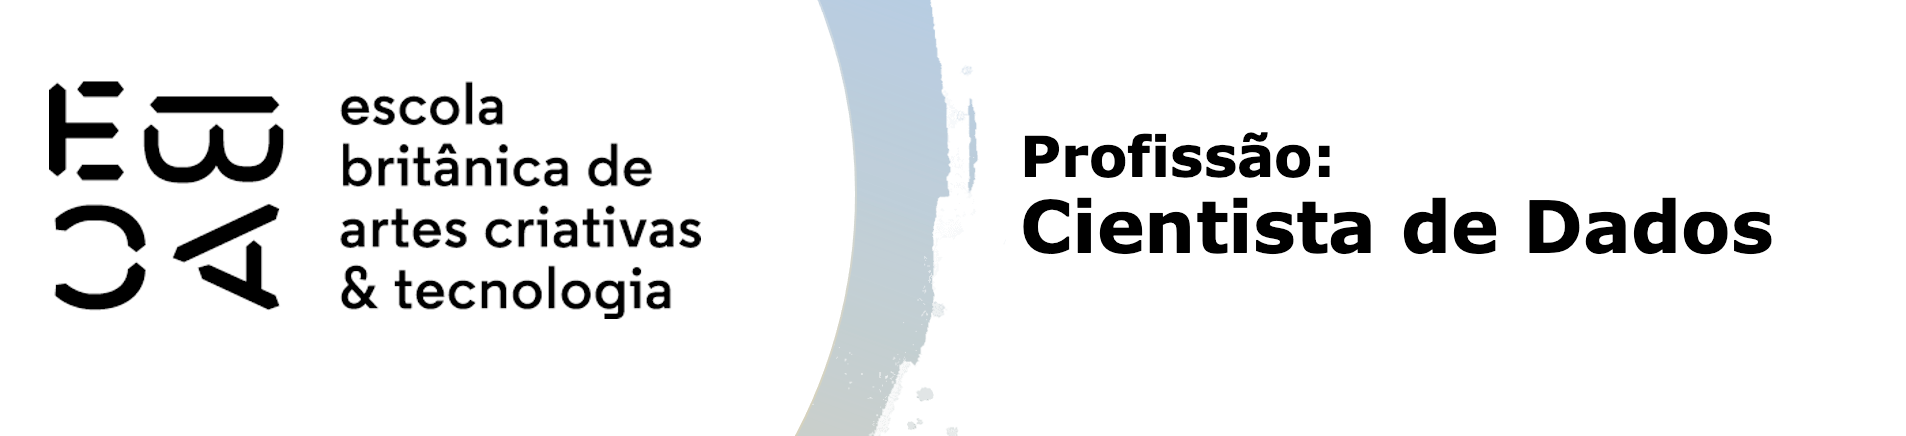

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [220]:
import patsy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.interpolate import interp1d



df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [221]:
valores_ausentes = df.isnull().sum()
print(valores_ausentes)

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64


In [222]:
df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [223]:
df_train = df[:'2015-12-01'].copy()
df_test = df['2016-01-01':].copy()

df_train['log_renda']=np.log(df_train['renda'])
df_test['log_renda']=np.log(df_test['renda'])

In [224]:
formula = 'log_renda ~ C(posse_de_imovel) + qtd_filhos + idade + tempo_emprego + 1'

X1 = patsy.dmatrices(formula, data=df_train)
res = sm.OLS(X1[0], X1[1]).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                 1.103e+05
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        02:01:08   Log-Likelihood:            -8.0490e+05
No. Observations:              600000   AIC:                         1.610e+06
Df Residuals:                  599996   BIC:                         1.610e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.3826      0.005   1693.373      0.000       8.373       8.392
C(posse_de_imovel)[T.S]     0.1790      0.003     69.703      0.000       0.174       0.184
qtd_filhos                       0          0        nan        nan           0           0
idade                      -0.0056      0.000    -50.285      0.000      -0.006      -0.005
tempo_emprego               0.1317      0.000    650.147      0.000       0.131       0.132
==============================================================================
Omnibus:                      891.428   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.178
Skew:                          -0.048   Prob(JB):                    2.13e-173
Kurtosis:                       2.850   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [225]:
# Fazendo uma verificação de como fica o modelo sem a variável qtd_filhos
# Pois apresenta coeficiente estimado de 0, erro padrão de 0 e estatística t e valor p não disponíveis (NaN)

formula = 'log_renda ~ C(posse_de_imovel) + idade + tempo_emprego + 1'

X1 = patsy.dmatrices(formula, data=df_train)
res = sm.OLS(X1[0], X1[1]).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                 1.103e+05
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        02:01:32   Log-Likelihood:            -8.0490e+05
No. Observations:              600000   AIC:                         1.610e+06
Df Residuals:                  599996   BIC:                         1.610e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.3826      0.005   1693.373      0.000       8.373       8.392
C(posse_de_imovel)[T.S]     0.1790      0.003     69.703      0.000       0.174       0.184
idade                      -0.0056      0.000    -50.285      0.000      -0.006      -0.005
tempo_emprego               0.1317      0.000    650.147      0.000       0.131       0.132
==============================================================================
Omnibus:                      891.428   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.178
Skew:                          -0.048   Prob(JB):                    2.13e-173
Kurtosis:                       2.850   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Não houve impacto significativo no modelo, então vou mantê-lo sem a variável 'qtd_filhos'

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

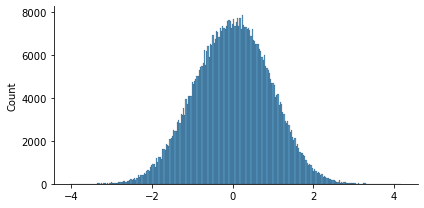

In [9]:
sns.displot(res.resid, height=3, aspect=2);

In [226]:
resid_df = pd.DataFrame({'Residuos': res.resid})
resid_summary = resid_df['Residuos'].describe()
resid_summary

count    6.000000e+05
mean     5.782492e-15
std      9.254904e-01
min     -3.968573e+00
25%     -6.393251e-01
50%      1.240188e-02
75%      6.445758e-01
max      4.108581e+00
Name: Residuos, dtype: float64

O gráfico mostra que os resíduos do modelo apresentam uma distribuição bem próxima da Normal.
Além disso, podemos observar que os resíduos têm uma média próxima de zero, mas apresentam uma dispersão considerável em relação à média. Além disso, a presença de valores extremos indica que o modelo ainda pode ter dificuldade em explicar completamente a variação nos dados.

<AxesSubplot:ylabel='log_renda'>

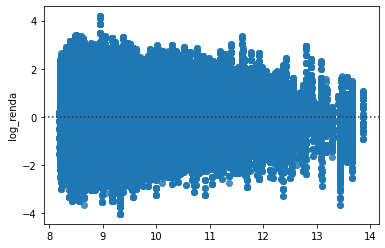

In [10]:
sns.residplot(x=res.predict(), y='log_renda', data=df_train)

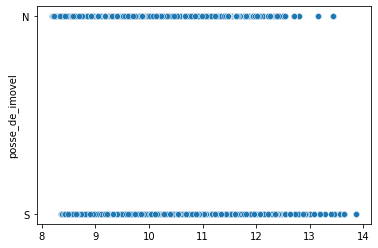

In [11]:
sns.scatterplot(x = res.predict(), y = 'posse_de_imovel', data=df_train);

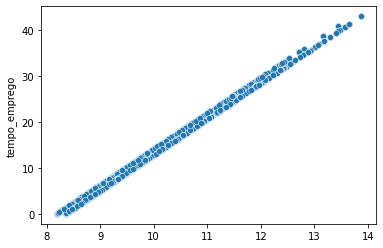

In [12]:
sns.scatterplot(x = res.predict(), y = 'tempo_emprego', data=df_train);

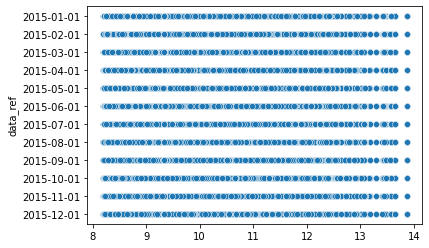

In [13]:
sns.scatterplot(x = res.predict(), y = 'data_ref', data=df_train);

<AxesSubplot:>

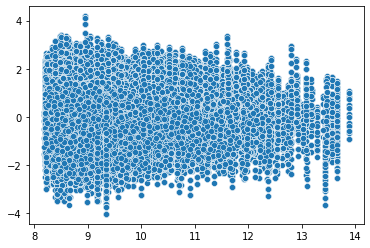

In [14]:
sns.scatterplot(x = res.predict(), y = res.resid)

In [227]:
df_encoded = pd.get_dummies(df_train, columns=['posse_de_imovel'])
df_relevant = df_encoded[['log_renda', 'posse_de_imovel_S', 'tempo_emprego']]

correlation_matrix = df_relevant.corr()

correlation_matrix

,log_renda,posse_de_imovel_S,tempo_emprego
log_renda,1.000000,0.064862,0.646058
posse_de_imovel_S,0.064862,1.000000,0.004089
tempo_emprego,0.646058,0.004089,1.000000


### Conclusões

- A variável 'log_renda' tem uma correlação positiva moderada com a variável 'tempo_emprego' (0.646058). Isso sugere que há uma tendência de aumento da renda com o aumento do tempo de emprego.

- A variável 'posse_de_imovel_S' (representando a posse de imóvel, codificada como 'S') tem uma correlação muito baixa com as outras variáveis ('log_renda' e 'tempo_emprego').
    - A correlação entre 'posse_de_imovel_S' e 'log_renda' é muito próxima de zero (0.064862), o que indica que a posse de imóvel não possui uma relação forte com a renda.
    - A correlação entre 'posse_de_imovel_S' e 'tempo_emprego' também é muito baixa (0.004089), o que sugere que a posse de imóvel não está fortemente relacionada ao tempo de emprego.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

**Observação:** Ao tentar realizar o influence plot com todas as variáveis da base df_train o código não finalizava, mesmo depois de horas rodando, talvez pelo excesso de variáveis, como as distribuições de residuos para os intervalos de data foram homogêneos eu tomei a liberdade de cortar a base treino apenas para conseguir rodar o código deste trecho do exercício.

In [15]:
df_train_short = df_train[:'2015-02-01']
df_train_short.reset_index(inplace=True)
df_train_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               100000 non-null  object 
 1   index                  100000 non-null  int64  
 2   sexo                   100000 non-null  object 
 3   posse_de_veiculo       100000 non-null  object 
 4   posse_de_imovel        100000 non-null  object 
 5   qtd_filhos             100000 non-null  int64  
 6   tipo_renda             100000 non-null  object 
 7   educacao               100000 non-null  object 
 8   estado_civil           100000 non-null  object 
 9   tipo_residencia        100000 non-null  object 
 10  idade                  100000 non-null  int64  
 11  tempo_emprego          100000 non-null  float64
 12  qt_pessoas_residencia  100000 non-null  float64
 13  renda                  100000 non-null  float64
 14  log_renda              100000 non-nul

In [16]:
reg = smf.ols('log_renda ~ tempo_emprego', data=df_train_short).fit()

<timed exec>:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 48min 9s, sys: 20min 15s, total: 1h 8min 25s
Wall time: 20min 3s


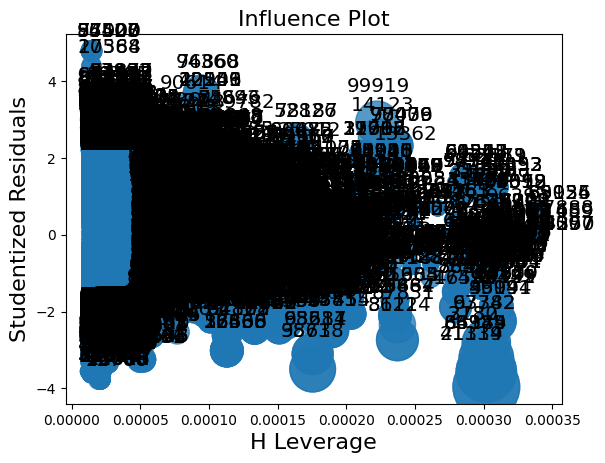

In [228]:
%%time

fig = sm.graphics.influence_plot(reg, criterion="cooks")
fig.show()

In [229]:
%%time

outlier_info = reg.get_influence().summary_frame()
outlier_info

CPU times: user 43min 39s, sys: 16min 9s, total: 59min 49s
Wall time: 16min 29s


,dfb_Intercept,dfb_tempo_emprego,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.000559,-0.002102,3.452484e-06,-0.455318,0.000033,-0.002628,-0.455316,-0.002628
1,-0.001965,-0.001201,1.037480e-05,-1.269066,0.000013,-0.004555,-1.269071,-0.004555
2,0.002695,0.000295,9.992248e-06,1.288340,0.000012,0.004470,1.288345,0.004470
3,0.000583,-0.000406,1.712708e-07,0.121779,0.000023,0.000585,0.121779,0.000585
4,-0.006399,0.004472,2.063289e-05,-1.332007,0.000023,-0.006424,-1.332014,-0.006424
...,...,...,...,...,...,...,...,...
99993,0.001226,0.000175,2.174584e-06,0.600192,0.000012,0.002085,0.600190,0.002085
99995,0.000784,0.000081,8.389498e-07,0.373386,0.000012,0.001295,0.373384,0.001295
99997,-0.000318,0.002750,7.408925e-06,0.777955,0.000024,0.003849,0.777953,0.003849
99998,0.002116,0.002842,2.530036e-05,1.883436,0.000014,0.007113,1.883464,0.007114


In [230]:
# Calculando os resíduos da regressão e as estatísticas descritivas dos resíduos
residuos = reg.resid
estatisticas = residuos.describe()
print(estatisticas)

count    8.341900e+04
mean     6.560717e-15
std      7.485224e-01
min     -2.965944e+00
25%     -5.009916e-01
50%      4.978852e-04
75%      5.037300e-01
max      3.580194e+00
dtype: float64


Devido à complexidade visual do gráfico, procurei novas formas de conseguir insumos para a análise. Ao analisar as estatísticas descritivas dos resíduos, alguns pontos podem indicar a presença de outliers:

- O valor mínimo (min) e o valor máximo (max) dos resíduos são significativamente diferentes de zero. No seu caso, o valor mínimo é -3.152938 e o valor máximo é 3.631691. Valores extremamente altos ou baixos podem indicar a presença de outliers.

- O desvio padrão (std) dos resíduos é de 0.7555811, o que indica que os resíduos têm uma dispersão considerável. Um desvio padrão alto pode indicar a presença de outliers.

- Os percentis (25%, 50%, 75%) também podem fornecer informações úteis. Nesse caso, o valor do percentil de 25% é -0.5080083, o valor do percentil de 50% é -0.0001006913 e o valor do percentil de 75% é 0.5053646. A presença de outliers pode causar uma assimetria nos percentis, ou seja, uma diferença significativa entre os valores dos percentis inferior e superior.

Portanto, considerando as estatísticas descritivas analisadas, parece haver indícios da presença de outliers nos resíduos da regressão.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [18]:
df_train_cut = df_train[['posse_de_imovel', 'tempo_emprego', 'log_renda']]

df_train_cut.head(2)

,posse_de_imovel,tempo_emprego,log_renda
data_ref,,,
2015-01-01,N,16.717808,9.318131
2015-01-01,N,9.600000,7.793508


In [19]:
# Matriz de correlação de Spearman

df_train_cut.corr(method='spearman')

,tempo_emprego,log_renda
tempo_emprego,1.000000,0.531836
log_renda,0.531836,1.000000


In [20]:
# VIF

variaveis = ['tempo_emprego', 'posse_de_imovel']

dum = pd.get_dummies(df_train_cut[variaveis], drop_first=True)
dum.head(2)

,tempo_emprego,posse_de_imovel_S
data_ref,,
2015-01-01,16.717808,0
2015-01-01,9.600000,0


In [21]:
vif(dum.values, 1)

1.7135721995585422

In [22]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(dum, i) for i in range(dum.shape[1])]
vars_vif["Feature"] = dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,1.71,tempo_emprego
1,1.71,posse_de_imovel_S


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

As métricas de desempenho obitdas nos fornecem algumas informações sobre a qualidade dos modelos de regressão ajustados.

- Ambos os modelos têm valores de R-quadrado e R-quadrado ajustado semelhantes, indicando que eles explicam cerca de 42% da variabilidade nos dados de renda (np.log(renda) ou log_renda, dependendo do modelo).

- As estatísticas F são altas em ambos os modelos, sugerindo que há uma relação estatisticamente significativa entre as variáveis independentes e a variável dependente.

- As diferenças entre os modelos estão no número de variáveis independentes (Df Model) e nas estatísticas associadas a essas variáveis (coef, std err, t, P>|t|, [0.025, 0.975]). O primeiro modelo possui 5 variáveis independentes, enquanto o segundo possui apenas 3.